In [113]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.transforms as tfs
import matplotlib.pyplot as plt
import seaborn as sns

from torch.nn.functional import cross_entropy
from torchvision.datasets import MNIST
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
from torch.nn import Module
from sklearn.datasets import make_moons
from torch.nn import functional as F

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

# Задание 1

Решить задачу классификации ирисов при помощи нейронных сетей. Вывести архитектуру модели а также ее метрику на полном наборе данных. Поэкспереминтируйте с моделью (измените архитектуру, увеличьте/уменьшите количество эпох, измените оптимизатор, увеличьте/уменьшите батч). Покажите переобучение/недообучение а также рабочую модель с метрикой на валидации около 0.95.

In [16]:
iris = load_iris()

X = torch.tensor(iris["data"], dtype=torch.float32)
y = torch.tensor(iris["target"])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

In [17]:
# Создаём датасет
dataset = TensorDataset(X, y)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_val, y_val)

# Создаём загрузчики данных
# Во время обучения они будут подгружать батчи 
dataloader = DataLoader(dataset, batch_size=8)
train_dataloader = DataLoader(train_dataset, batch_size=8)
val_dataloader = DataLoader(test_dataset, batch_size=8)

In [ ]:
for batch in train_dataloader:
  print(f"x - {batch[0]}\n y - {batch[1]}")

# Задание 2
Создайте классификатор изображений MNIST. Поэксперементируйте со слоями/функциями активации/количество нейронов. Сделайте вывод по вашим экспериментам. Обоснуйте выбор своей архитектуры. Попробуйте интерпреитровать ваши результаты.

In [84]:
import os
import torchvision.transforms as tfs

from torchvision.datasets import MNIST

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

## Обучение модели

# Задание 3
Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`). Обучите модель используя ваши слои на датасетe.

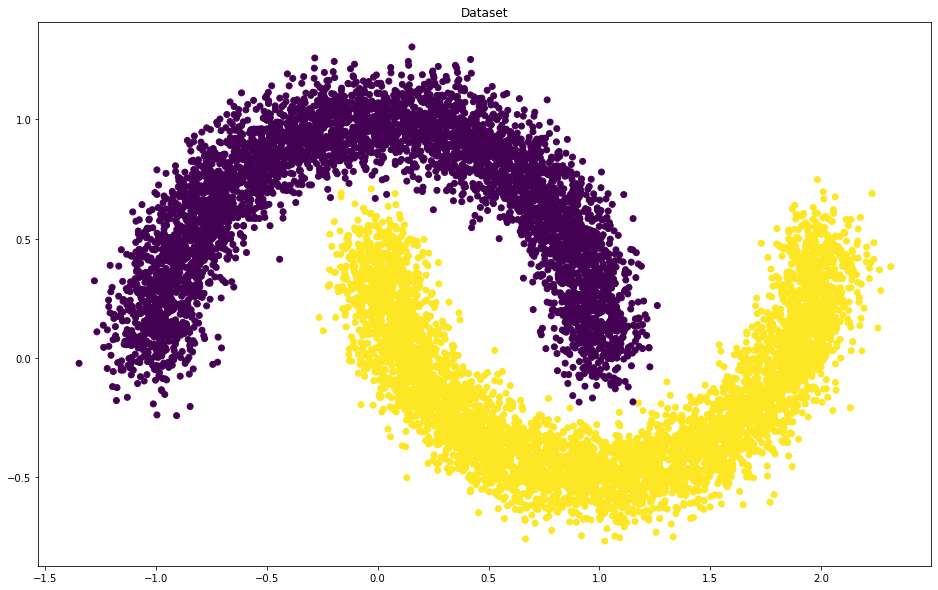

In [107]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

In [108]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [102]:
class LinearRegression(nn.Module):
  def __init__(self, in_features: int, out_features: int, bias: bool = True):
    super().__init__()
    # Код здесь

  def forward(self, x):
    # Код здесь

In [103]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

Ответ:

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False

for epoch in range(max_epochs):
  for it, (X_batch, y_batch) in enumerate(train_dataloader):
    # обнуление градиента
    outp = linear_regression(X_batch)
    loss = loss_function(outp, y_batch)
    
    # обратное распотранение

    losses.append(loss.detach().flatten()[0])
    optimizer.step()
    probabilities = F.sigmoid(outp)
    preds = (probabilities > 0.5).type(torch.long)
    batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
    
    if (it + epoch * len(train_dataloader)) % 100 == 0:
      print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
    current_weights = linear_regression.weights.detach().clone()
    if (prev_weights - current_weights).abs().max() < tol:
      print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
      stop_it = True
      break
    prev_weights = current_weights
  if stop_it:
    break

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [ ]:
sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [115]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        output = model(x_batch)
        preds = torch.sigmoid(output)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [ ]:
from sklearn.metrics import accuracy_score

dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
dataset_dataloader = DataLoader(dataset, batch_size=128)

accuracy_score(y, np.array([1 if y >= 0.5 else 0 for y in predict(dataset_dataloader, linear_regression)]))